In [1]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/github/opengeos/segment-anything/blob/pypi/notebooks/predictor_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

In [2]:
import sys


In [3]:
if 'google.colab' in sys.modules:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())

    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install git+https://github.com/ChaoningZhang/MobileSAM.git

    !mkdir images
    !wget -P images https://raw.githubusercontent.com/ChaoningZhang/MobileSAM/master/notebooks/images/picture1.jpg
    !wget -P images https://raw.githubusercontent.com/ChaoningZhang/MobileSAM/master/notebooks/images/picture2.jpg

    !wget https://raw.githubusercontent.com/ChaoningZhang/MobileSAM/master/weights/mobile_sam.pt



PyTorch version: 2.3.0+cu121
Torchvision version: 0.18.0+cu121
CUDA is available: False
  Cloning https://github.com/ChaoningZhang/MobileSAM.git to /tmp/pip-req-build-3m3p97qu
  Running command git clone --filter=blob:none --quiet https://github.com/ChaoningZhang/MobileSAM.git /tmp/pip-req-build-3m3p97qu
  Resolved https://github.com/ChaoningZhang/MobileSAM.git to commit c12dd83cbe26dffdcc6a0f9e7be2f6fb024df0ed
  Preparing metadata (setup.py) ... done
  Created wheel for mobile-sam: filename=mobile_sam-1.0-py3-none-any.whl size=42434 sha256=0a0dd31334c56d5cbe990c1aafa153756bcf8536f65fa54062c1d77f103b0d5f
  Stored in directory: /tmp/pip-ephem-wheel-cache-0u7lvd64/wheels/43/b1/9d/1c1b33c31d4c54f0a502f9c48b655f87213ab01e55d09cf4ef
Successfully built mobile-sam
--2024-06-18 11:47:44--  https://raw.githubusercontent.com/ChaoningZhang/MobileSAM/master/notebooks/images/picture1.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108

In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2


In [5]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [6]:
image = cv2.imread('images/picture2.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

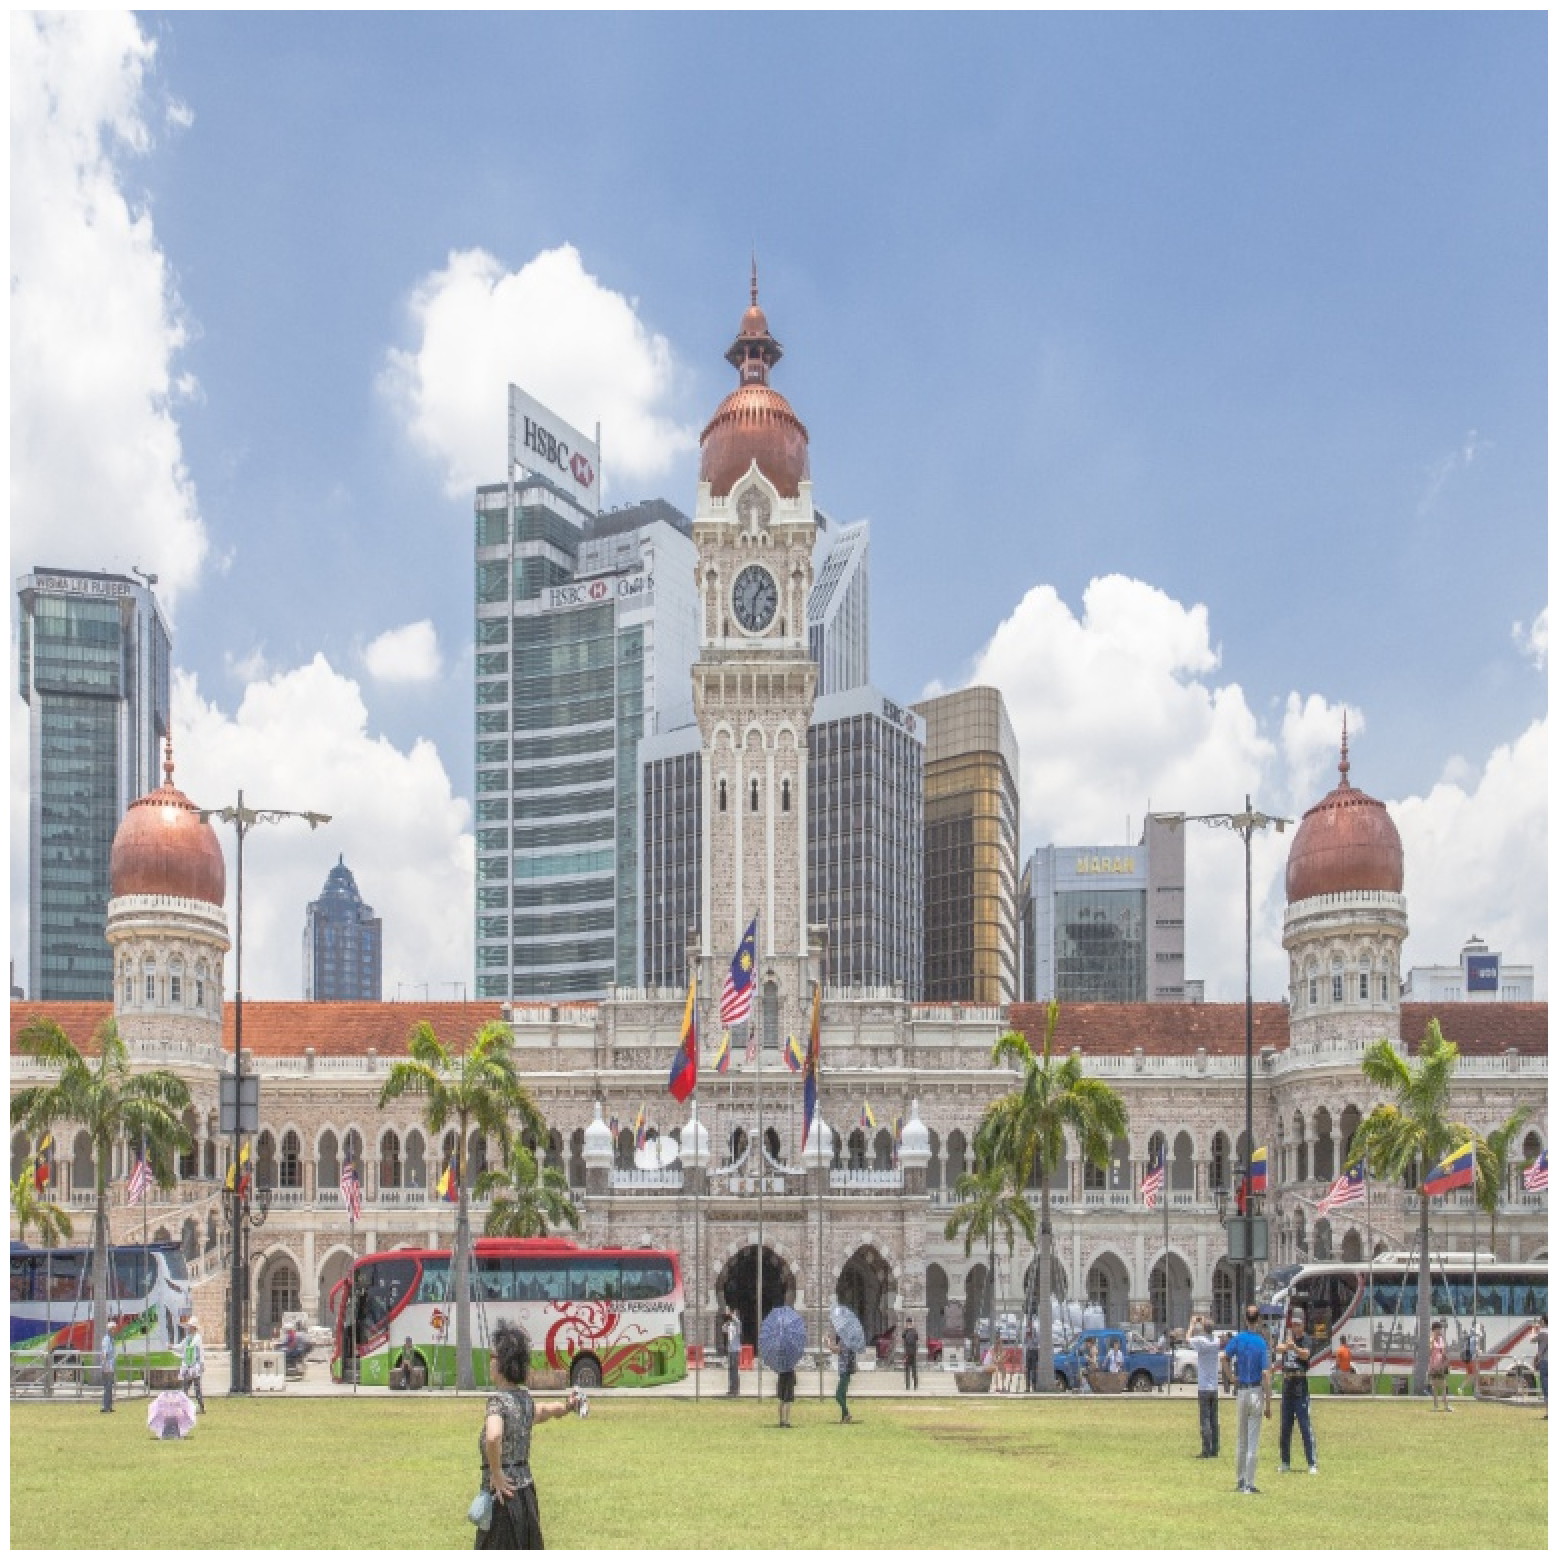

In [7]:
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

In [13]:
import sys
sys.path.append("..")
from mobile_sam import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "/content/mobile_sam.pt"
model_type = "vit_t"

device = "cuda" if torch.cuda.is_available() else "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
sam.eval()

mask_generator = SamAutomaticMaskGenerator(sam)

In [14]:
masks = mask_generator.generate(image)

In [15]:
print(len(masks))
print(masks[0].keys())

95
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


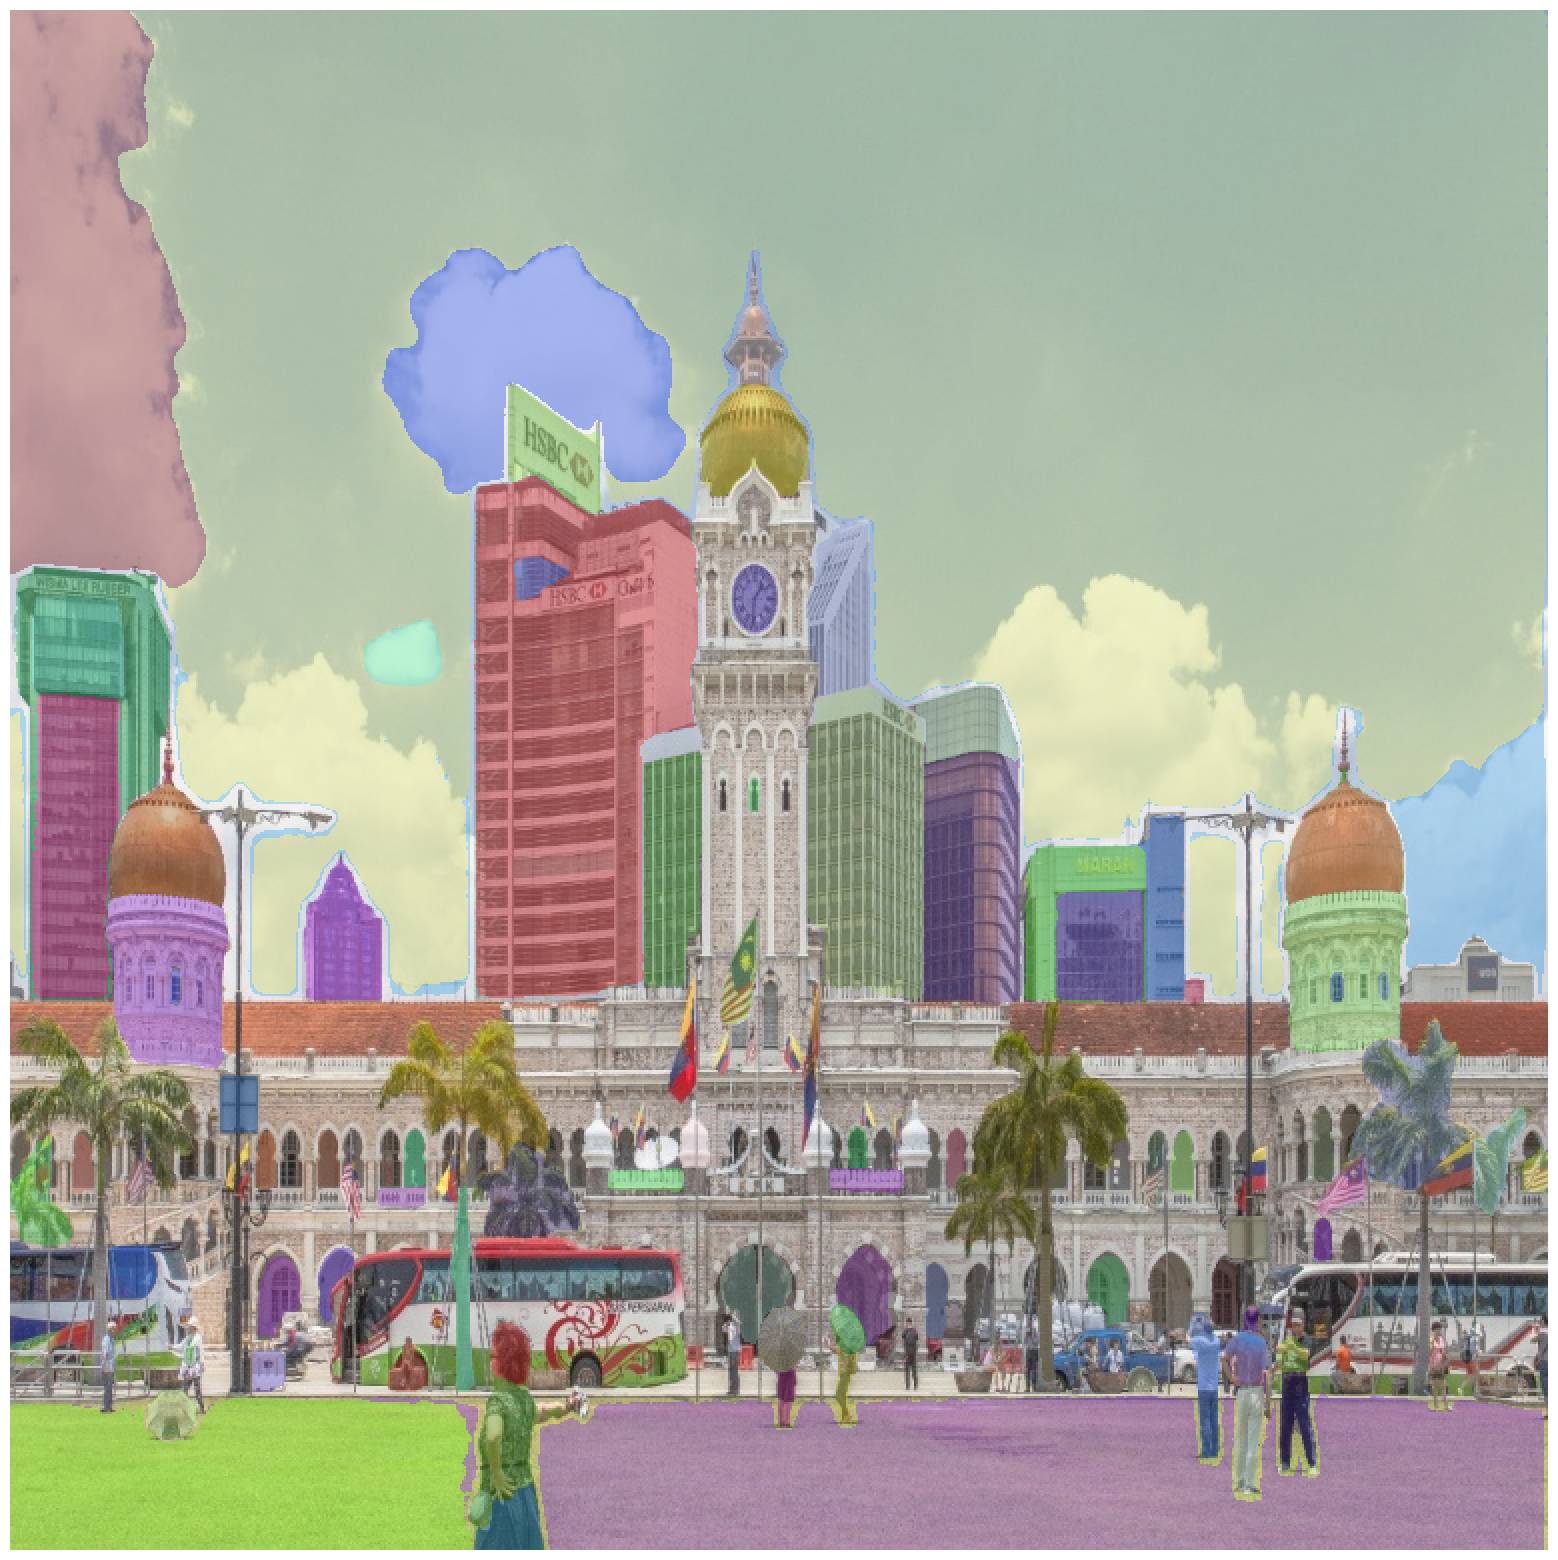

In [16]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

In [17]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [18]:
masks2 = mask_generator_2.generate(image)

In [19]:
len(masks2)

213

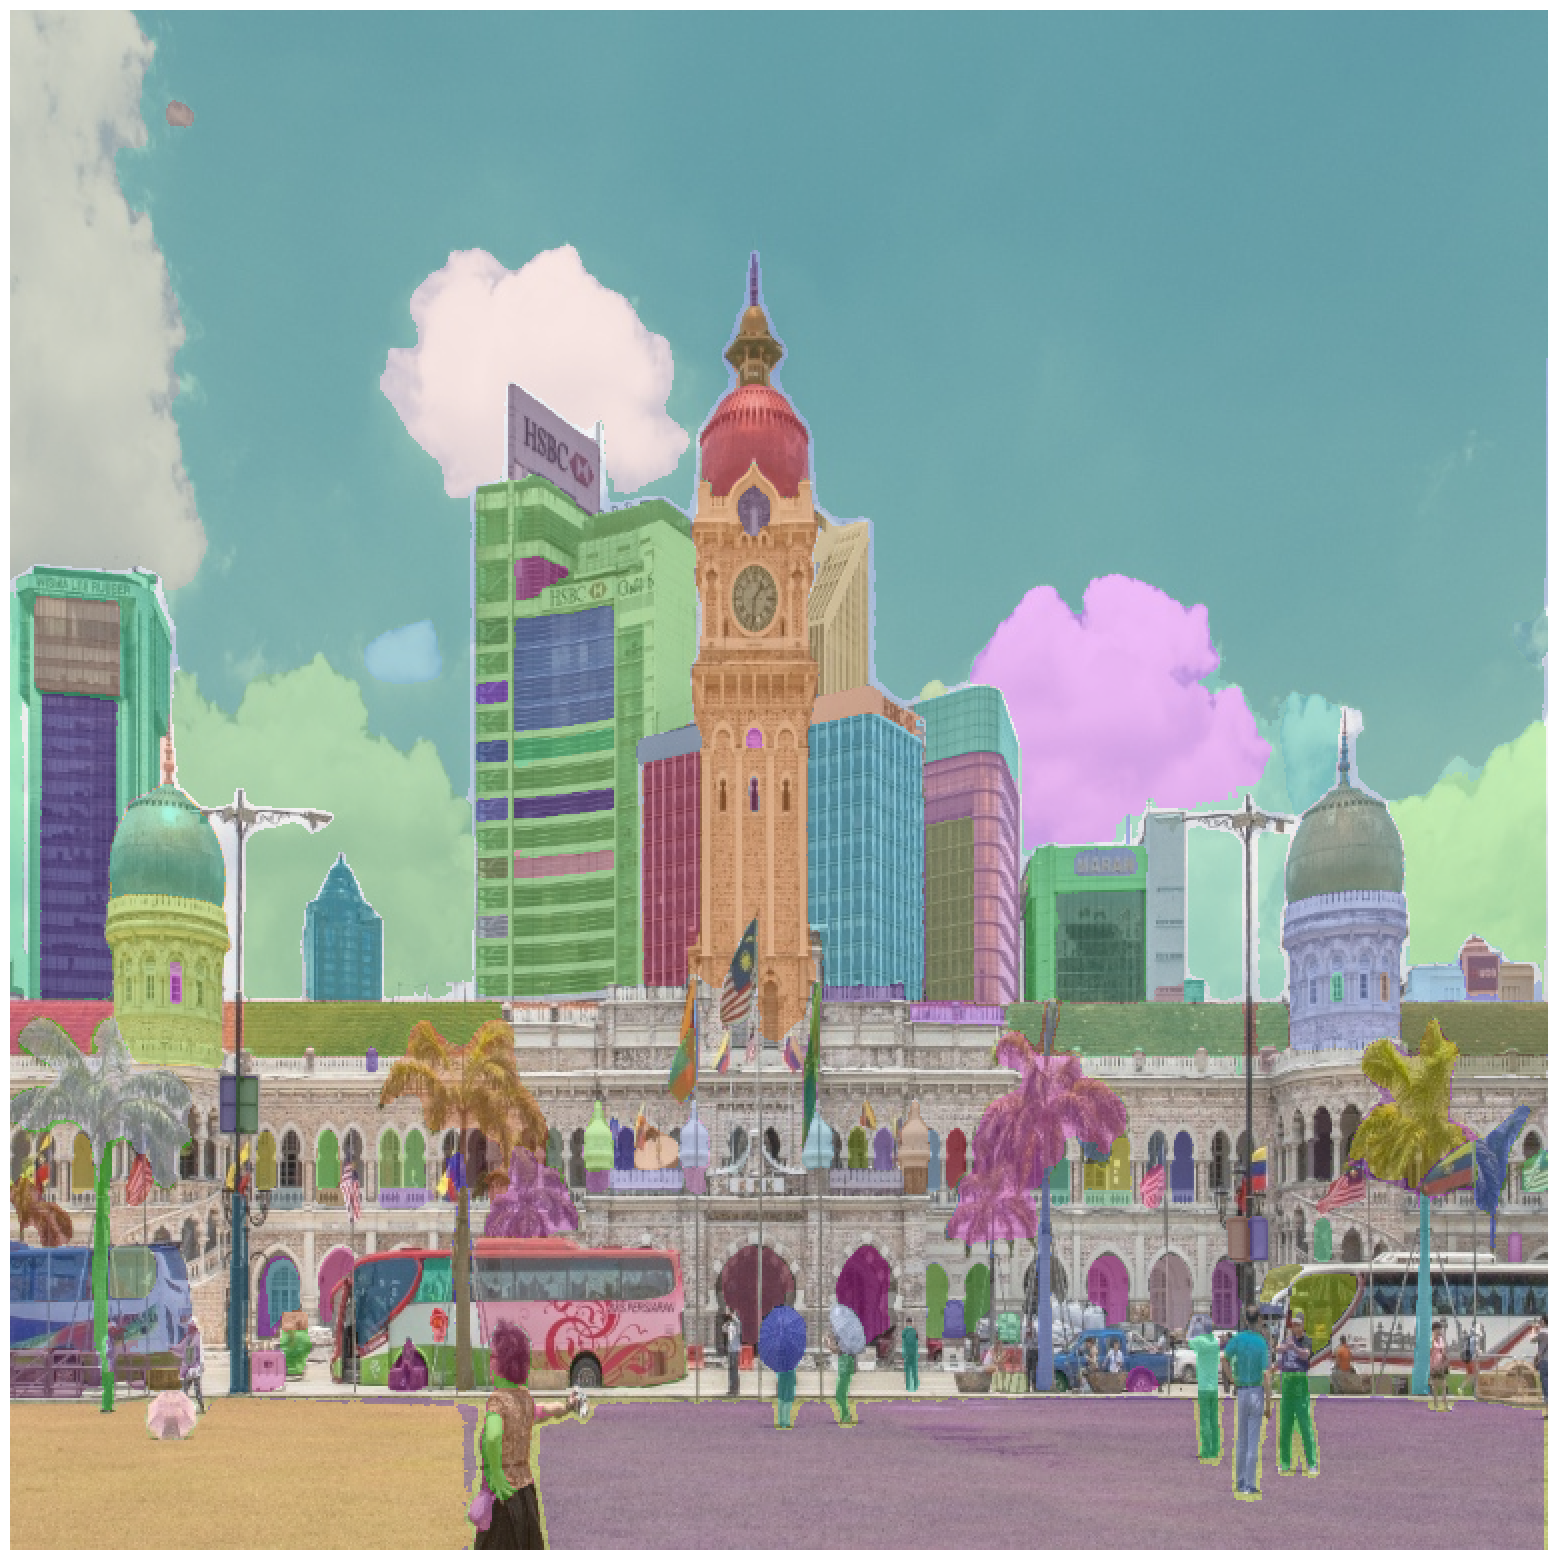

In [20]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show()